In [2]:
import os
import sys
import random
from pathlib import Path
import osgeo  #Needed for use on Windows only
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
import geopandas as gpd
from datetime import datetime
import sqlalchemy as sa
%matplotlib inline

In [3]:
sys.path.append(r"../../src/collectcube")
from samplegen import *
from db import *

In [10]:
## aoi_in = shapefile or geopkg with polygon objet(s) sample form
aoi_in = Path("../../data/LUCinLA_paraguay/lgSamp/lgSampDistricts.shp")
out_dir = '../../data/LUCinLA_paraguay/lgSamp'
local_db_path = 'C:/GISprojects/ParaguayValidation/smDistricts/landcover.db'
## reference .tif with target crs and resolution
ref_ras = Path("../../data/LUCinLA_paraguay/samp_ras.tif")

res = 10

In [11]:
samp_polys = gpd.read_file(aoi_in)
samp_dists = samp_polys['UNQ'].values.tolist()
print(samp_dists)

['D0506_Caaguazu_DJMF', 'D0725_Itapua_AV', 'D1012_AltoParana_SC', 'D1016_AltoParana_MP', 'D1409_Canindeyu_LP']


## Get random sample within polygon

In [12]:
def get_multi_poly_sample(aoi_in,sampsize, ref_ras, db_path, out_dir):
    pt_file_out = os.path.join(out_dir,'samp_pts.shp')
    box_file_out = os.path.join(out_dir,'samp_boxes.shp')
    
    samp_polys = gpd.read_file(aoi_in)
    samp_dists = samp_polys['UNQ'].values.tolist()
    for i,subply in enumerate(samp_dists):
        if subply == None:
            print('oops -- No UNQ')
        else:
            print(subply)
            gs = get_sample_in_poly(aoi_in, sampsize, seed=992, subpoly=subply)
            gs_shift = move_points_to_pixel_centroids(gs, ref_ras, write_pts=False)
            maxpid = get_max_id_in_db(db_path)
            print(f'maxid={maxpid}')
            if i==0:
                pts = get_full_point_file(gs_shift, pt_file_out, res, lastpt=maxpid, write_pts=False)
                ptsdf = make_pixel_table(pts,subply)
            else:
                pts_sub = get_full_point_file(gs_shift, pt_file_out, res, lastpt=maxpid, write_pts=False)
                ptsdf = make_pixel_table(pts_sub,subply)
                pts = pd.concat([pts,pts_sub], axis=0)
    
            #print(ptsdf.tail())
            make_pixel_table_in_db(ptsdf, db_path, 'append')
            
    centpts = pts[pts['Center']==1]
    centpts.to_file(pt_file_out, driver='ESRI Shapefile')
    boxes = make_pixel_boxes_from_pts(pts, box_file_out, res, write_boxes=True)
    
    return pts

In [13]:
samp = get_multi_poly_sample(aoi_in,500, ref_ras, local_db_path, out_dir)

D0506_Caaguazu_DJMF
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=5499
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D0725_Itapua_AV
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=5999
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D1012_AltoParana_SC
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=6499
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D1016_AltoParana_MP
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=6999
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D1409_Canindeyu_LP
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=7499
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels


In [14]:
table_check = check_table(local_db_path,'pixels')

             PID  Center     cent_X     cent_Y   cent_lat  cent_long  ransamp  \
71995  0007999_4       0  3255940.0 -3073290.0 -24.288644 -54.514667        1   
71996  0007999_5       0  3255960.0 -3073290.0 -24.288644 -54.514449        1   
71997  0007999_6       0  3255940.0 -3073300.0 -24.288725 -54.514656        1   
71998  0007999_7       0  3255950.0 -3073300.0 -24.288725 -54.514547        1   
71999  0007999_8       0  3255960.0 -3073300.0 -24.288725 -54.514438        1   

       checked  PID0  PID1           sampgroup  
71995        0  7999     4  D1409_Canindeyu_LP  
71996        0  7999     5  D1409_Canindeyu_LP  
71997        0  7999     6  D1409_Canindeyu_LP  
71998        0  7999     7  D1409_Canindeyu_LP  
71999        0  7999     8  D1409_Canindeyu_LP  


<Axes: >

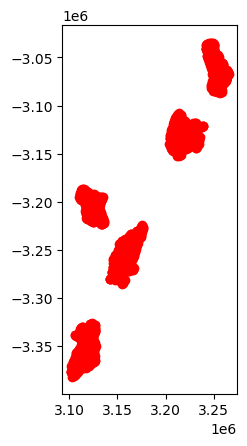

In [15]:
pts = gpd.read_file(os.path.join(out_dir,'samp_pts.shp'))

fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
pts.plot(ax=ax, color='r')